In [1]:
# conda install -c conda-forge openexr

In [2]:
import os
import ntpath
import re

from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

#import runai.ga

#from nvidia.dali.pipeline import Pipeline
#import nvidia.dali.ops as ops
#import nvidia.dali.types as types

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow.python.client import device_lib

import datetime

import cv2
import pandas as pd
import random
from IPython.display import Image
from pathlib import Path

import glob
import json
#import OpenEXR
import imageio

In [3]:
path_to_images = "C:\\tmp\\dump_truck4"
#path_to_images = "C:\\tmp\\test"

In [4]:
included_extensions = ['json'] #, 'jpg','jpeg', 'bmp', 'png', 'gif']
obj_data_files = [fn for fn in os.listdir(path_to_images)
                      if any(fn.endswith(ext) for ext in included_extensions)]

print("Found ", len(obj_data_files), " json files")

Found  1  json files


In [5]:
def load_obj_data( jsonfile ):
    json_path = os.path.join( path_to_images, jsonfile )
    with open( json_path, 'r' ) as infile:
        data = json.load( infile )
    return data

In [6]:
obj_data_idx = random.randint( 0, len( obj_data_files ) - 1 )
obj_data_path = obj_data_files[ obj_data_idx ]
obj_data = load_obj_data(obj_data_path)

obj_data["frame"]["files"]

['C:\\tmp\\test\\0001.png',
 'C:\\tmp\\test\\test_img0001.png',
 'C:\\tmp\\test\\test_z0001.exr',
 'C:\\tmp\\test\\test_z_img0001.png',
 'C:\\tmp\\test\\test_class0001.png',
 'C:\\tmp\\test\\test_class_img0001.png']

In [7]:
def get_file_name(json_data):
    img_files_pre = json_data["frame"]["files"]
    img_files = [os.path.normpath(f) for f in img_files_pre]
    path_img           = [f for f in img_files if re.match(r'.*_img[0-9]+\.(png|jpeg|jpg)', f)][0]
    path_img_z_map     = [f for f in img_files if re.match(r'.*_z[0-9]+\.exr', f)][0]
    path_img_class     = [f for f in img_files if re.match(r'.*_class[0-9]+\.(png|jpeg|jpg)', f)][0]
    path_img_z_img     = [f for f in img_files if re.match(r'.*_z_img[0-9]+\.(png|jpeg|jpg)', f)][0]
    path_img_class_img = [f for f in img_files if re.match(r'.*_class_img[0-9]+\.(png|jpeg|jpg)', f)][0]
    return (path_img, path_img_z_map, path_img_class, path_img_z_img, path_img_class_img )

In [8]:
def img_preprocess_load( img_path ):
    img = mpimg.imread( img_path )
    img = img_preprocess( img )
    return img

path_img           =  C:\tmp\test\test_img0001.png
path_img_z_map     =  C:\tmp\test\test_z0001.exr
path_img_class     =  C:\tmp\test\test_class0001.png
path_img_z_map     =  C:\tmp\test\test_z_img0001.png
path_img_class_img =  C:\tmp\test\test_class_img0001.png
(540, 960, 4)
(540, 960, 3)
(540, 960, 4)
(540, 960)
(540, 960, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Class 2')

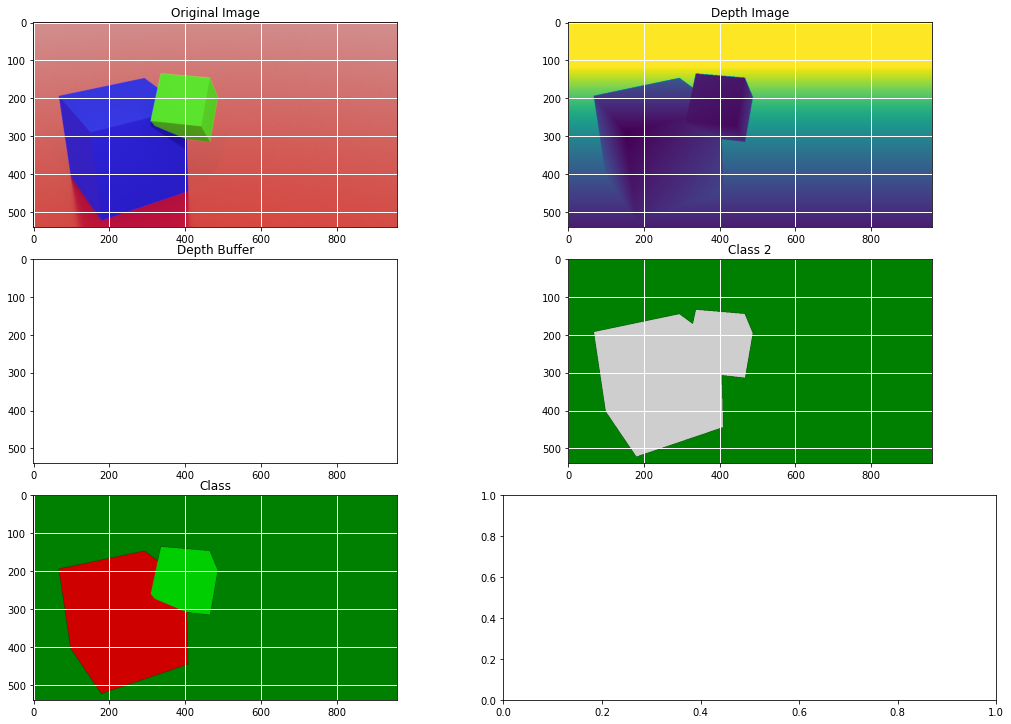

In [9]:
path_img, path_img_z_map, path_img_class, path_img_z_img, path_img_class_img = get_file_name(obj_data)
print("path_img           = ", path_img)
print("path_img_z_map     = ", path_img_z_map)
print("path_img_class     = ", path_img_class)
print("path_img_z_map     = ", path_img_z_img)
print("path_img_class_img = ", path_img_class_img)

#pp = "C:\\tmp\\dump_truck4\\minetruck_img0310.jpg"
#my_file = Path(pp)
#print(pp, " is a file ", os.path.isfile(pp) )
#print(pp, " is a file ", os.path.isdir(pp) )
#print(pp, " is a file ", my_file.exists() )

#img             = mpimg.imread( pp )
#img_z_map       = img
img           = mpimg.imread( path_img )
img_z_map     = imageio.imread( path_img_z_map )
img_class     = mpimg.imread( path_img_class )
img_z_img     = mpimg.imread( path_img_z_img )
img_class_img = mpimg.imread( path_img_class_img )

print (img.shape)
print (img_z_map.shape)
print (img_class.shape)
print (img_z_img.shape)
print (img_class_img.shape)
#print (golden[512][640])


fig, axs = plt.subplots( 3, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ][ 0 ].set_facecolor("green")
#axs[ 0 ][ 0 ].fill_between([0,1],[1,1], color="none", hatch="X", edgecolor="b", linewidth=0.0)
axs[ 0 ][ 0 ].imshow( img )
axs[ 0 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ][ 0 ].set_title( 'Original Image' )

axs[ 1 ][ 0 ].set_facecolor("green")
axs[ 1 ][ 0 ].imshow( img_z_map )
axs[ 1 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ][ 0 ].set_title( 'Depth Buffer' )

axs[ 2 ][ 0 ].set_facecolor("green")
axs[ 2 ][ 0 ].imshow( img_class )
axs[ 2 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 2 ][ 0 ].set_title( 'Class' )

axs[ 0 ][ 1 ].set_facecolor("green")
axs[ 0 ][ 1 ].imshow( img_z_img )
axs[ 0 ][ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ][ 1 ].set_title( 'Depth Image' )

axs[ 1 ][ 1 ].set_facecolor("green")
axs[ 1 ][ 1 ].imshow( img_class_img )
axs[ 1 ][ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ][ 1 ].set_title( 'Class 2' )

#show_image("minetruck_img1001.jpg")
#obj_data["frame"][0]["objects"]["object_0000"]

In [10]:
def img_preprocess( img ):
    img = img[ 60:135, :, : ]
    img = cv2.cvtColor( img, cv2.COLOR_RGB2YUV )
    img = cv2.GaussianBlur( img, ( 3, 3 ), 0 )
    img = cv2.resize( img, ( 200, 66 ) )
    img = img / 255
    return img

In [11]:
def img_rm_alpha( img_orig ):
    img = np.copy( img_orig )
    h, w, cp = img.shape
    if cp == 4:
        for y in range( h - 1 ):
            for x in range( w - 1 ):
                img[y][x][3]=1
    return img

Text(0.5, 1.0, 'Preprocessed Image')

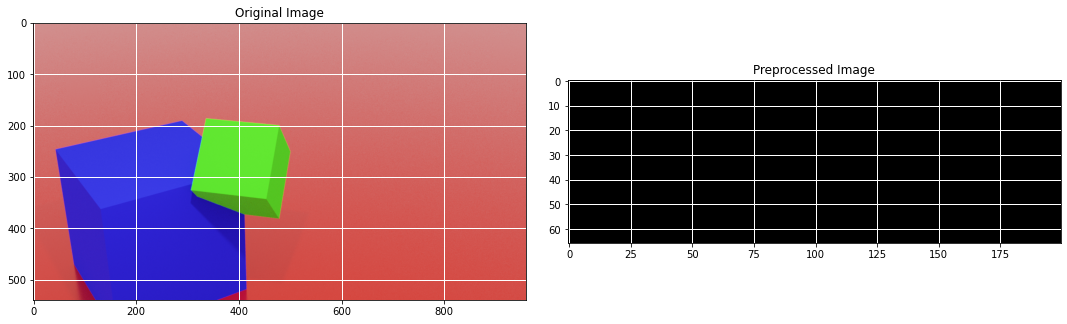

In [30]:
img = "test_img0001.png"
img_path = os.path.join( path_to_images, img )
img_original = mpimg.imread( img_path )
img_preprocessed = img_preprocess_load( img_path )

fig, axs = plt.subplots( 1, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ].imshow( img_original )
axs[ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ].set_title( 'Original Image' )
axs[ 1 ].imshow( img_preprocessed )
axs[ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ].set_title( 'Preprocessed Image' )

In [31]:
def img_rect( img_orig, rects ):
    img = img_rm_alpha( img_orig )
    h, w, cp = img.shape
    print ("H,W,CP = ", h, w, cp)
    for rect in rects:
        (p1, p2, color) = rect
        p1s = ( int(p1[0] * w), int(h - p1[1] * h) )
        p2s = ( int(p2[0] * w), int(h - p2[1] * h) )
        cv2.rectangle( img, p1s, p2s, color, 5 )
    alpha = 0.4  # Transparency factor.
    # Following line overlays transparent rectangle over the image
    img = cv2.addWeighted(img, alpha, img_orig, 1 - alpha, 0)
    return img

def rndColor():
    r = min(random.randint(0, 8) * 32, 255)
    g = min(random.randint(0, 8) * 32, 255)
    b = min(random.randint(0, 8) * 32, 255)
    return (r, g, b)

def get_bb(data, objName):
    c = rndColor()
    print ("Color for ", objName, " is ", c)

    objData = data["frame"]["objects"][objName]
    if "bb2dWithChildren" in objData:
        bb2d = objData["bb2dWithChildren"]
    elif "bb2d" in objData:
        bb2d = objData["bb2d"]
    if bb2d:
        rect = ( ( bb2d["x1"], bb2d["y1"] ), ( bb2d["x2"], bb2d["y2"] ), c )
    else:
        rect = ( ( 0, 0 ), ( 0, 0 ) )
    return rect

object_0000	Cube	bb2d=(0.045,-0.13,0.43,0.65)
object_0001	Camera	bb2d=(0.66,1.6,0.66,1.6)
object_0002	Cube.001	bb2d=(0.32,0.29,0.52,0.65)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  540 960 4


Text(0.5, 1.0, 'Preprocessed Image')

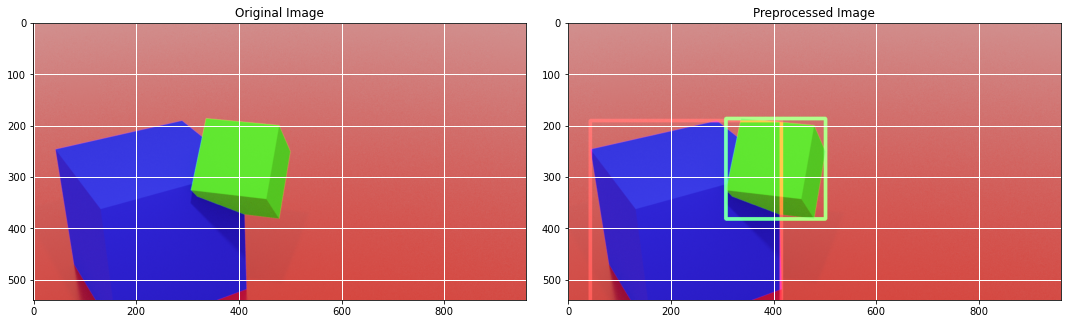

In [32]:
obj_data_files

jsonfile = "obj_data0001.json"
#jsonfile = "obj_data0935.json"
json_path = os.path.join( path_to_images, jsonfile )
with open(json_path, 'r') as infile:
    data = json.load(infile)

for keys,values in data["frame"]["objects"].items():
    if "bb2d" in values:
        print("{}\t{}\tbb2d=({:.2},{:.2},{:.2},{:.2})".format(keys,values["name"],values["bb2d"]["x1"],values["bb2d"]["y1"],values["bb2d"]["x2"],values["bb2d"]["y2"]) )
    if "bb2dWithChildren" in values:
        print("{}\t{}\tbb2dWC=({:.2},{:.2},{:.2},{:.2})".format(keys,values["name"],values["bb2dWithChildren"]["x1"],values["bb2dWithChildren"]["y1"],values["bb2dWithChildren"]["x2"],values["bb2dWithChildren"]["y2"]) )
#        keys, values["name"], print('{:.2f}'.format(values["bb2d"])))

#print(data["frame"][0]["objects"])
fig, axs = plt.subplots( 1, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ].imshow( img_original )
axs[ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ].set_title( 'Original Image' )

#objs = [ "Cube.000", "Cube.002", "Cube.003" ]
#objs = [ "Car Rig", "wheel.Ft.L", "wheel.Ft.R", "wheel.Bk.L", "wheel.Bk.R", "body", "Minetruck" ]
#objs = [ "Car Rig", "wheel.Ft.L", "wheel.Ft.R", "wheel.Bk.L", "wheel.Bk.R" ]
objs = [ "testcar-Body", "testcar-Wheel.Ft.L", "testcar-Wheel.Ft.R", "testcar-Wheel.Bk.L", "testcar-Wheel.Bk.R", "Car Rig" ]
rects = [ get_bb(data, o) for o in objs]

axs[ 1 ].imshow( img_rect(img_original, rects ) )
axs[ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ].set_title( 'Processed Image' )